In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-12-16 11:19:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2020-12-16 11:19:24 (44.4 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



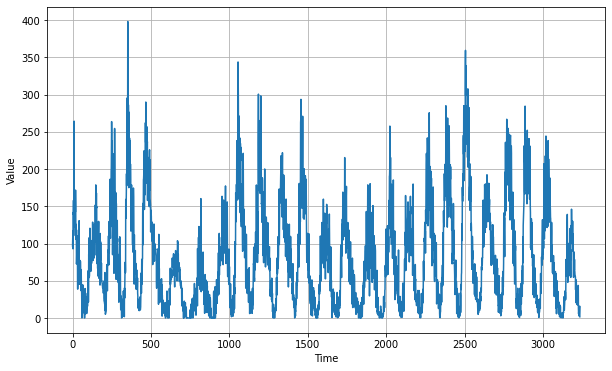

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

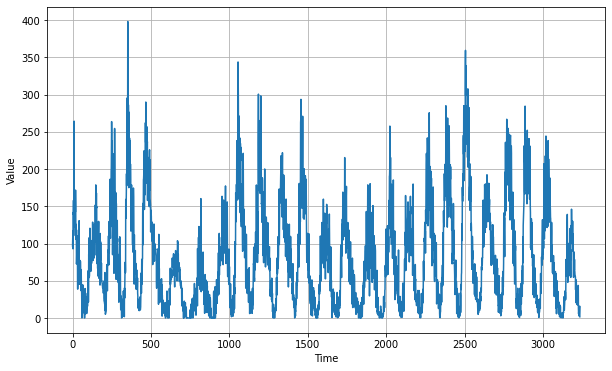

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 22ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 0s 24ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 0s 26ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 0s 26ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 0s 25ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 0s 25ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

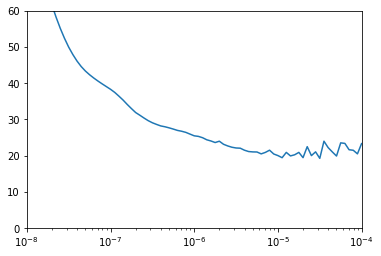

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 15ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 25.7614 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 22.0765 - mae: 22.5702
Epoch 4/500
30/30 [==============================] - 0s 15ms/step - loss: 20.4728 - mae: 20.9657
Epoch 5/500
30/30 [==============================] - 0s 15ms/step - loss: 19.7125 - mae: 20.2050
Epoch 6/500
30/30 [==============================] - 0s 14ms/step - loss: 19.2635 - mae: 19.7557
Epoch 7/500
30/30 [==============================] - 0s 14ms/step - loss: 18.5911 - mae: 19.0830
Epoch 8/500
30/30 [==============================] - 0s 14ms/step - loss: 18.1450 - mae: 18.6363
Epoch 9/500
30/30 [==============================] - 0s 14ms/step - loss: 18.1455 - mae: 18.6369
Epoch 10/500
30/30 [==============================] - 0s 14ms/step - loss: 19.8891 - mae: 20.3812
Epoch 11/500
30/30 [=========

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

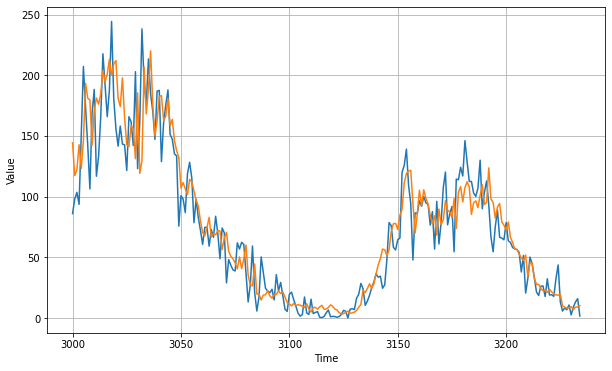

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.334175

<Figure size 432x288 with 0 Axes>

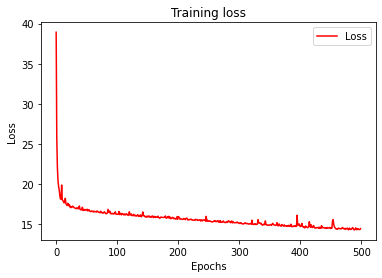

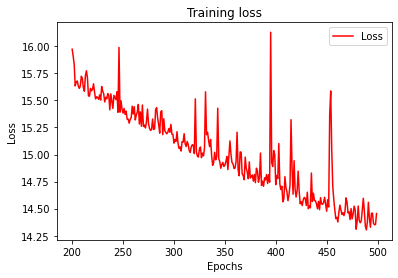

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [19]:
print(rnn_forecast)

[144.31438   117.35046   122.02133   142.75385   123.2001    146.02344
 193.34888   180.98436   179.69626   142.34503   170.74934   181.29674
 176.20105   184.6398    204.04497   194.42992   201.1211    213.05032
 200.1227    209.22119   212.08601   181.06175   174.20908   197.84161
 165.19298   142.72081   141.10367   158.41655   156.1127    131.2321
 185.49777   119.101265  129.22104   206.84496   168.14706   188.58324
 220.05048   175.90746   149.95825   162.48477   182.50435   183.18947
 162.68024   166.24236   180.9636    158.38905   163.66783   146.00557
 137.91127   132.34727   107.08214   111.493065  106.34901   101.63897
 114.20534   112.18288   104.45092    96.96219    92.117775   79.889336
  70.30123    67.594894   74.34116    82.94968    66.6931     69.735695
  68.5204     71.93369    71.633064   56.41419    65.92715    70.45241
  55.067665   50.731564   48.806767   45.25891    40.49167    50.306732
  40.65629    48.798855   60.11274    35.1432     27.285185   26.485073
  4